# Proof Of Concept

In [14]:
from Utility import ast_visualizer
from Utility import ast_utility
import ast
import os
import matplotlib.pyplot as plt
from Utility.code import Code

In [15]:
task_names=["A","B","C"]
task_list=dict()
for task in task_names:
    task_list[task]=os.listdir(f"Task03646/{task}")

In [16]:
def generate_code_list(embedding_length,use_split_embedding):
    code_list=dict()
    for task in task_names:
        code_list[task]=[]
        for file in task_list[task]:
            code_list[task].append(Code(open(f"Task03646/{task}/{file}"),task,file,embedding_length,use_split_embedding))
    
    return code_list


In [17]:
def get_maximum_tree_similarity(code1,code2):
    max_similarity=0
    max_sim_tree1=None
    max_sim_tree2=None

    index=0
    for tree1 in code1.get_trees():
        for tree2 in code2.get_trees():
            #Note: It's important to weight the similarity by the number of nodes in the tree because the diff returns the number of changes to apply to the first tree to make it equal to the second tree
            similarity=1-ast_utility.diff(tree1,tree2)/code1.get_trees_dim()[index]
            if(similarity>max_similarity):
                max_similarity=similarity
                max_sim_tree1=tree1
                max_sim_tree2=tree2
                
        index+=1

    return max_similarity,max_sim_tree1,max_sim_tree2

def get_maximum_jaccard_similarity(code1,code2):
    max_similarity=0
    max_sim_embedding1=None
    max_sim_embedding2=None

    for embedding1 in code1.get_embeddings():
        for embedding2 in code2.get_embeddings():
            similarity=ast_utility.jaccard(embedding1,embedding2)
            if(similarity>max_similarity):
                max_similarity=similarity
                max_sim_embedding1=embedding1
                max_sim_embedding1=embedding2

    return max_similarity,max_sim_embedding1,max_sim_embedding2

def calcualte_similarity_and_jaccard(code_list,task1,task2):
    similarity=[]
    jaccard=[]
    for i,code1 in enumerate(code_list[task1]):
        for j,code2 in enumerate(code_list[task2]):

            max_similarity,max_sim_tree1,max_sim_tree2=get_maximum_tree_similarity(code1,code2)
            similarity.append(max_similarity)

            max_jaccard,max_sim_embedding1,max_sim_embedding2=get_maximum_jaccard_similarity(code1,code2)
            jaccard.append(max_jaccard)
    return similarity,jaccard

In [18]:
code_list=generate_code_list(5,False)
similarity, jaccard=calcualte_similarity_and_jaccard(code_list,"A","A")


In [19]:
similarity2, jaccard2=calcualte_similarity_and_jaccard(code_list,"A","B")


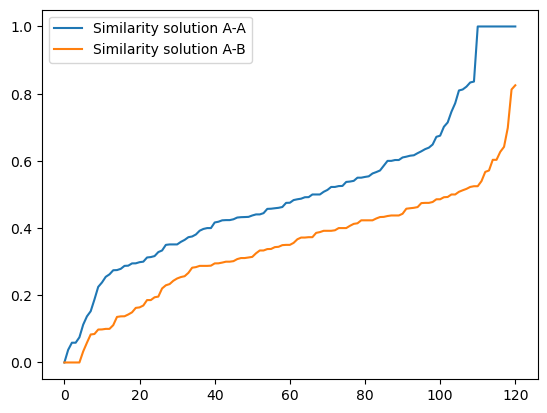

In [20]:
similarity.sort()
similarity2.sort()
plt.plot(similarity,label="Similarity solution A-A")
plt.plot(similarity2,label="Similarity solution A-B")
plt.legend()
plt.show()

Si evidenzia come l'indice di similarità tra soluzioni appartenenti allo stesso gruoppo hanno mediamente valore di similarità maggiore rispetto a quelle che risolvono lo stesso task, ma appartenendo ad un gruppo diverso. 
Questo fa ben sperare per la funzionalità della misura.

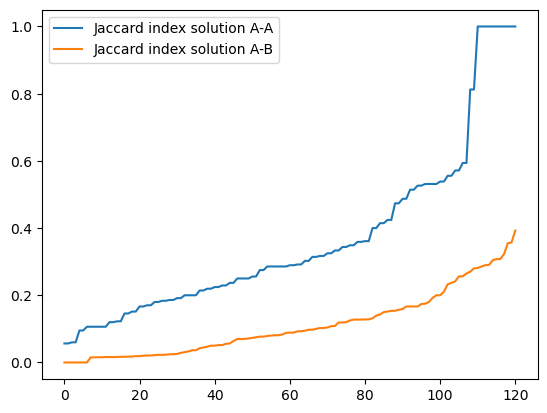

In [21]:
jaccard.sort()
jaccard2.sort()
plt.plot(jaccard,label="Jaccard index solution A-A")
plt.plot(jaccard2,label="Jaccard index solution A-B")
plt.legend()
plt.show()

Si evidenzia come l'indice di jaccard tra soluzioni appartenenti allo stesso gruppo hanno mediamente valore di similarità maggiore rispetto a quelle che risolvono lo stesso task, ma appartenendo ad un gruppo diverso. 
Differenziando meglio i gruppi e ottenendo performance migliore. Ulteriori valori di k vanno analizzati.

In [22]:
from Utility import diff_method
similarity_for_similar_code=[]
for i,code1 in enumerate(code_list["A"]):
    for j,code2 in enumerate(code_list["A"]):

        jaccard_similarity=code1.code_similarity(code2,diff_method.Diff_embedding)
        tree_similarity=code1.code_similarity(code2,diff_method.Diff_tree)
        
        similarity_for_similar_code.append((jaccard_similarity,tree_similarity))

similarity_for_dissimilar_code=[]
for i,code1 in enumerate(code_list["A"]):
    for j,code2 in enumerate(code_list["B"]):

        jaccard_similarity=code1.code_similarity(code2,diff_method.Diff_embedding)
        tree_similarity=code1.code_similarity(code2,diff_method.Diff_tree)
        
        similarity_for_dissimilar_code.append((jaccard_similarity,tree_similarity))

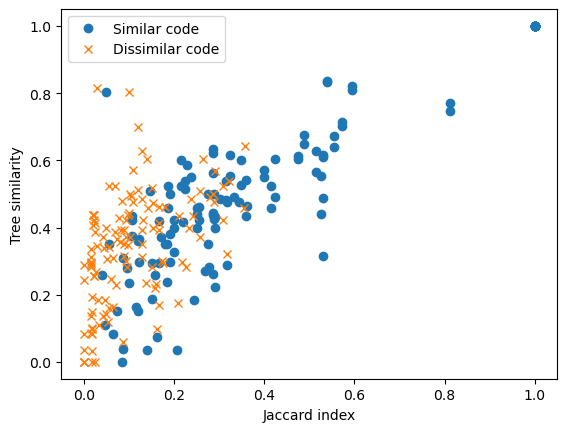

In [23]:
plt.plot([x[0] for x in similarity_for_similar_code],[x[1] for x in similarity_for_similar_code],label="Similar code",marker="o",linestyle="")
plt.plot([x[0] for x in similarity_for_dissimilar_code],[x[1] for x in similarity_for_dissimilar_code],label="Dissimilar code",marker="x",linestyle="")
plt.xlabel("Jaccard index")
plt.ylabel("Tree similarity")
plt.legend()
plt.show()

Per valori di k maggiori la jaccard sembra discriminare meglio codici simili con quelli dissimili.

In [24]:
task_list=os.listdir(f"Example/")

code_list=[]

for file in task_list:
    code_list.append(Code(open(f"Example/{file}"),task,file,5))

from Utility import diff_method
similarity_tags=[]
similarity_indexes=[]
for i,code1 in enumerate(code_list):
    for j,code2 in enumerate(code_list):
        if(i>=j):
            continue
    
        jaccard_similarity=code1.code_similarity(code2,diff_method.Diff_embedding)
        tree_similarity=code1.code_similarity(code2,diff_method.Diff_tree)
        
        similarity_indexes.append((jaccard_similarity,tree_similarity))
        similarity_tags.append((i+1,j+1))


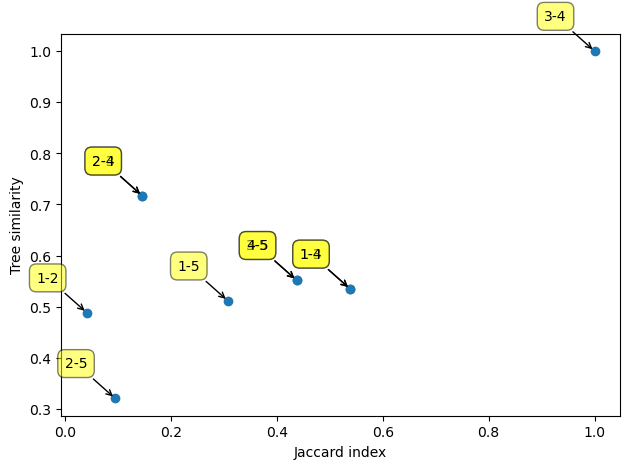

In [25]:
plt.subplots_adjust(bottom = 0.1)
plt.scatter(
    [x[0] for x in similarity_indexes], [x[1] for x in similarity_indexes], marker='o', cmap=plt.get_cmap('Spectral'))

for label, x, y in zip(similarity_tags, [x[0] for x in similarity_indexes],[x[1] for x in similarity_indexes]):
    plt.annotate(
        f"{label[0]}-{label[1]}",
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
plt.xlabel("Jaccard index")
plt.ylabel("Tree similarity")
plt.tight_layout()
plt.show()

In [26]:
len(similarity_indexes)

10